In [3]:
import os
import warnings

import mnmstpy as mnmst
import pandas as pd
import scanpy as sc
from sklearn.metrics.cluster import adjusted_rand_score

import logger as l

warnings.filterwarnings("ignore")

In [6]:
section_id = "151675"

input_dir = os.path.join('F:/sources/code/ST-SCSR/data/DLPFC', section_id)
adata = sc.read_visium(path=input_dir, count_file=section_id + '_filtered_feature_bc_matrix.h5')

sc.pp.calculate_qc_metrics(adata, inplace=True)
adata = adata[:, adata.var['total_counts'] > 100]
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.filter_genes(adata, min_cells=1)
hvg_filter = adata.var['highly_variable']
sc.pp.normalize_total(adata, inplace=True)
adata = adata[:, hvg_filter]
display(adata)

View of AnnData object with n_obs × n_vars = 3592 × 3001
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'spatial', 'hvg'
    obsm: 'spatial'

In [7]:
enhanced_adata, cell_spatial = mnmst.data_enhance(adata, k_nei=6, ratio=0.6)


Median distance to closest cell = 138.00362314084367
num_nbrs: 3001


In [8]:
sc.pp.pca(enhanced_adata, n_comps=50)
low_dim_x = enhanced_adata.obsm['X_pca']
expression = low_dim_x
spatial_network = cell_spatial

In [10]:
Ann_df = pd.read_csv(os.path.join('F:/sources/code/ST-SCSR/data/DLPFC', section_id, section_id + '_truth.txt'), sep='\t', header=None,
                     index_col=0)
Ann_df.columns = ['Ground Truth']

In [11]:
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']

In [12]:
import numpy as np

dim = 7
def min_max_normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))
count_sub = np.apply_along_axis(min_max_normalize, 0, expression)
# count_sub =expression

In [13]:
import numpy as np


def Ge(n):
    decay_factor = 0.01
    mat_Ge = np.zeros((n, n))

    np.fill_diagonal(mat_Ge, 1)
    dist_matrix = np.abs(np.outer(np.arange(1, n + 1), np.arange(1, n + 1)) - 1)
    mat_Ge = np.exp(-decay_factor * dist_matrix)
    mat_Ge = (mat_Ge - np.min(mat_Ge)) / (np.max(mat_Ge) - np.min(mat_Ge)) * 0.1
    np.fill_diagonal(mat_Ge, 1)
    return mat_Ge

In [15]:


from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


def svd(mat, k):
    u, s, vt = np.linalg.svd(mat, full_matrices=False)
    return u[:, :k], np.diag(s[:k]), vt[:k, :]

svd_result_x = svd(np.transpose(count_sub), dim)
mat_be = np.abs(svd_result_x[0] @ np.sqrt(svd_result_x[1]))
mat_ge = Ge(dim)
mat_fe = np.abs(np.sqrt(svd_result_x[1]) @ svd_result_x[2])


svd_result_k = svd(spatial_network.toarray(), dim)
mat_bs = np.abs(svd_result_k[0] @ np.sqrt(svd_result_k[1]))
mat_gs = Ge(dim)
mat_fs = np.abs(np.sqrt(svd_result_k[1]) @ svd_result_k[2])

In [33]:

from ST_SCSR import ST_SCSR


max_epoch = 30

n_spot = count_sub.shape[0]
n_neighbor = 15
init_W = cosine_similarity(count_sub)

cos_init = np.zeros((n_spot, n_spot))
for i in range(n_spot):
    vec = init_W[i, :]
    distance = vec.argsort()[:: -1]
    for t in range(n_neighbor + 1):
        y = distance[t]
        cos_init[i, y] = init_W[i, y]
# result = join_nmf1(np.transpose(count_sub), mat_be, mat_Ge, mat_fe,  max_epoch)
# result = join_nmf_2(np.transpose(count_sub), mat_be, mat_ge, mat_fe, mat_bs,  mat_fs, spatial_network.toarray(), max_epoch)
# result = join_nmf(np.transpose(count_sub), mat_be, mat_Ge, mat_fe, mat_bs, mat_Gs, mat_fs, spatial_network.toarray(), max_epoch)
# result = join_nmf_3(np.transpose(count_sub), mat_be, mat_ge, mat_fe, mat_bs, mat_fs, spatial_network.toarray(), max_epoch,cos_init)
# result = join_nmf_4(np.transpose(count_sub), mat_be, mat_ge, mat_fe, mat_bs, mat_fs, spatial_network.toarray(), max_epoch,spatial_network.toarray())
result = ST_SCSR(np.transpose(count_sub), mat_be, mat_ge, mat_fe, mat_bs, mat_fs, spatial_network.toarray(),
                    max_epoch, cos_init)
#

##err1  0 is:  84.82368500494893
##err2  0 is:  28.923066688834027
##err3  0 is:  37.42005765062169
##err4  0 is:  54.37020427866035
##err1  1 is:  27.7008151284526
##err2  1 is:  25.554263969698315
##err3  1 is:  30.32229451489837
##err4  1 is:  45.59389164450396
##err1  2 is:  20.70453169934264
##err2  2 is:  24.646845856446184
##err3  2 is:  26.05651578970951
##err4  2 is:  35.592153476562885
##err1  3 is:  17.89355257768394
##err2  3 is:  24.526530431888414
##err3  3 is:  23.090225814547527
##err4  3 is:  29.346660261523546
##err1  4 is:  16.392624421169764
##err2  4 is:  24.48057728218668
##err3  4 is:  20.905518082409902
##err4  4 is:  22.192988577516676
##err1  5 is:  15.48698889462461
##err2  5 is:  24.47483800086536
##err3  5 is:  19.208820829741338
##err4  5 is:  17.32656327482988
##err1  6 is:  14.893139487274308
##err2  6 is:  24.478564939818153
##err3  6 is:  17.839942476112807
##err4  6 is:  13.926327378954936
##err1  7 is:  14.477193056356787
##err2  7 is:  24.4848647077

In [59]:
import igraph as ig
import leidenalg
from natsort import natsorted

l.logger.info("[cluster] begin")
sources, targets = result[2].nonzero()
ans_weight = result[2][sources, targets]
g = ig.Graph(directed=True)
g.add_vertices(result[2].shape[0])  # this adds adjacency.shape[0] vertices
g.add_edges(list(zip(sources, targets)))
g.es['weight'] = ans_weight


In [71]:
# 尝试在学到的亲和图上直接执行leiden聚类算法。我们在单细胞上的聚类算法基本都失效了，也该尝试空间转录组领域的了。
partition_type = leidenalg.RBConfigurationVertexPartition
# clustering proper
partition_kwargs = {'weights': np.array(g.es['weight']).astype(np.float64), 'n_iterations': -1, 'seed': 42,
                    'resolution_parameter': 0.33}

part = leidenalg.find_partition(g, partition_type, **partition_kwargs)
# store output into adata.obs
groups = np.array(part.membership)
leiden_label = pd.Categorical(
    values=groups.astype('U'),
    categories=natsorted(map(str, np.unique(groups))),
)
print(leiden_label)
adjusted_rand_score(pd.Categorical(adata.obs['Ground Truth']).codes, leiden_label)

['5', '0', '3', '1', '4', ..., '4', '3', '3', '2', '3']
Length: 3592
Categories (7, object): ['0', '1', '2', '3', '4', '5', '6']


0.6092689433840139

In [77]:
adata.obs['spe_pred'] = leiden_label

In [78]:
from uti1l import refine

In [79]:
weights_adj = cell_spatial.A

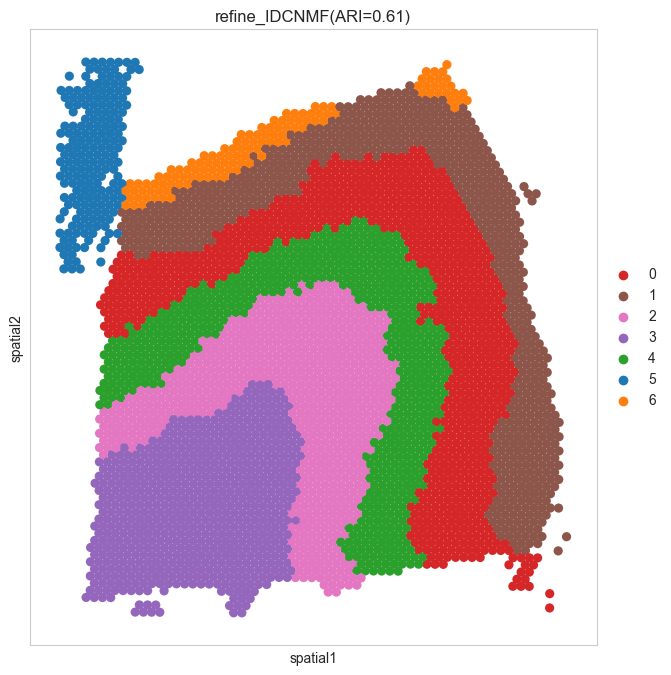

In [82]:
refined_pred = refine(sample_id=adata.obs.index.tolist(), pred=adata.obs['spe_pred'].tolist(), dis=weights_adj,
                      shape="hexagon")
adata.obs["refined_pred"] = refined_pred
adata.obs["refined_pred"] = adata.obs["refined_pred"].astype('category')
stACN_ari = adjusted_rand_score(pd.Categorical(adata.obs['Ground Truth']).codes, adata.obs['spe_pred'])
refine_ari = adjusted_rand_score(pd.Categorical(adata.obs['Ground Truth']).codes, adata.obs['refined_pred'])

# sc.pl.spatial(adata, color='spe_pred', palette=colors_leiden, title='IDCNMF(ARI=%.2f)' % stACN_ari, alpha_img=0, size=1.6)

sc.pl.spatial(adata, color='refined_pred', palette=colors_leiden, title='refine_IDCNMF(ARI=%.2f)' % refine_ari, alpha_img=0, size=1.6)
colors_leiden=['#d62728','#8c564b','#e377c2','#9467bd','#2ca02c','#1f77b4', '#ff7f0e']
colors_truth=['#d62728','#2ca02c','#8c564b',  '#e377c2', '#9467bd', '#9467bd' ]
# sc.pl.spatial(adata, color='Ground Truth', palette=colors_truth, title='Ground Truth', alpha_img=0, size=1.6)
